---
title: "Decision tree algorithm"
date: 2019-01-25T19:14:46+05:30
draft: False
author: "Nitin Patil"

---

Here we will implement the Decision Tree algorithm and compare our algorithm's performance with decision trees from `sklearn.tree`

Decision Trees are a non-parametric supervised learning method used for classification and regression. The goal of decision tree is to learn simple decision rules from training data and use those rules to predict target value for test data.

### Mathematical formulation

Given training data  $X$ , of shape $[N$ x $D]$ and a label vector $y$ of shape $[N$ x $K]$, (where $N$ is number of samples, $D$ is number of features, $K$ is number of labels) a decision tree recursively partitions the space such that the samples with the same labels are grouped together.



Let the data at $m$ node represented by $X$. For each candidate split $\theta = (j, t_m)$ consisting of a feature $j$ and threshold $t_m$, partition the data into $X\_l$ and $X\_r$ subsets

$$ X\_l(\theta) = {(X, y) | X\_j <= t_m } $$


$$X\_r(\theta) = X \setminus X\_l(\theta)$$


The impurity at $m$ node is computed using an impurity function $F(X)$, the choice of which depends on the task being solved (classification or regression)

Select the parameters $\theta = (j, t_m)$ for an optimal partition at a given $m$ node that minimises the impurity at left and right nodes. This will be acheived by maximizing below function.

$$ Q(X, j, t_m) = F(X) - \dfrac{|X_l|}{|X|} F(X_l) - \dfrac{|X_r|}{|X|} F(X_r) $$

Recurse for subsets $X\_l$ and $X\_r$ until...
- `max_depth` the maximum allowable depth of tree is reached, 
- number of samples in a node are less than `min_samples_split` or equal to 1

#### Classification criteria

If a target is a classification outcome taking on values $0,1,…,K-1$, for node $m$, representing a region $R_m$ with $N_m$ observations, let $p_i$ be the fraction of the samples of the $i$-th class in the dataset $X_m$.
$$p_i = \dfrac{1}{N_m} \sum_{x_i \in R_m} I(y_i = k)$$

Common measure of impurity are

- Gini $$F(X_m) = 1 -\sum_{i = 1}^K p_i^2$$

- Entropy $$F(X_m) = -\sum_{i = 1}^K p_i \log_2(p_i)$$


#### Regression criteria

If the target is a continuous value, then for node $m$, representing a region $R_m$ with $N_m$ observations, common criteria to minimise as for determining locations for future splits are Mean Squared Error, which minimizes the L2 error using mean values at terminal nodes, and Mean Absolute Error, which minimizes the L1 error using median values at terminal nodes.
 

$$ \hat{y} = \dfrac{1}{N_m}\sum_{x_i \in X}y_i$$

- Mean Squared Error (variance)

$$F(X_m) = \dfrac{1}{N_m} \sum_{x_j \in N_m}(y_j - \hat{y})^2$$

- Mean Absolute Error

$$F(X_m) = \dfrac{1}{N_m} \sum_{x_j \in N_m}|(y_j - \hat{y})|$$

- mad_median - Mean deviation from the median 
$$F(X_m) = \dfrac{1}{N_m} \sum_{x_j \in N_m} |y_j - \mathrm{med}(y)| $$

### Implementation

**Specification:**

1. Inherit our `DecisionTree` class from `sklearn.BaseEstimator`
- class constructor parameters: 

    `max_depth` - maximum allowable depth of the tree (`numpy.inf` by default)
    
    `min_samples_split` - the minimum number of samples in a node for splitting to be done (2 by default)
    
    `criterion` - criterion to use for data split, `gini` by default)
   
- the class has several methods: `fit`, `predict` and `predict_proba`;
- the`fit` method takes the matrix of instances `X` and a target vector `y` (`numpy.ndarray` objects) and returns an instance of the class `DecisionTree` representing the decision tree trained on the dataset `(X, y)` according to parameters set in the constructor; 
- the `predict_proba` method takes the matrix of instances `X` and returns the matrix `P` of a size `X.shape[0] x K`, where `K` is the number of classes and $p_{ij}$ is the probability of an instance in $i$-th row of `X` to belong to class $j \in \{1, \dots, K\}$.
- the `predict` method takes the matrix of instances `X` and returns a prediction vector; in case of classification, prediction for an instance $x_i$ falling into leaf $L$ will be the class, mostly represented among instances in $L$. In case of regression, it'll be the mean value of targets for all instances in leaf $L$.

In [220]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification, make_regression, load_digits, load_boston
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, mean_squared_error

Let's fix `random_state` (a.k.a. random seed) beforehand.

In [221]:
RANDOM_STATE = 17

In [222]:
# Classification criterion functions
def entropy(y):    
    P = [len(y[y==k]) / len(y) for k in np.unique(y)]
    return -1 * np.dot(P, np.log2(P))

def gini(y):
    P = [len(y[y==k]) / len(y) for k in np.unique(y)]
    return 1 - np.dot(P, P)

# Regression criterion functions
def variance(y):
    return np.var(y)

def mad_median(y):
    return np.mean(np.abs(y-np.median(y)))

# Dictionary for easy mapping with input string
criterion_dict = {'entropy': entropy,
                   'gini': gini,
                   'mse': variance,
                   'mad_median' : mad_median}

In [223]:
# Target prediction functions

# the most popular class in leaf
def classification_leaf(y):
    return np.bincount(y).argmax()

# the mean of all values in a leaf
def regression_leaf(y):
    return np.mean(y)

The `Node` class represents a node in the decision tree.

In [229]:
class Node():
    
    def __init__(self, feature_idx=0, threshold=0, labels=None, left=None, right=None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.labels = labels
        self.left = left
        self.right = right

In [230]:
class DecisionTree(BaseEstimator):
    
    def __init__(self, max_depth=np.inf, min_samples_split=2, 
                 criterion='gini', debug=False):
        
        params = {'max_depth': max_depth,
                  'min_samples_split': min_samples_split,
                  'debug' : debug,
                  'criterion' : criterion}
                
        super(DecisionTree, self).set_params(**params)
        
        self._criterion_fun = criterion_dict[self.criterion]
        
        if self.criterion in ['mse', 'mad_median']:
            self._leaf_value = regression_leaf
        else:
            self._leaf_value = classification_leaf
            
        if debug:
            print("DecisionTree")
            print(f"max_depth: {self.max_depth}, min_samples_split: {self.min_samples_split}, \
                  criterion: {self.criterion}, debug: {self.debug}")
        
    
    # A functional returns the gain achieved if we split the data at given feature and threshold value
    #
    def _functional(self, X, y, feature_idx, threshold):
        if threshold is np.nan:
            return 0
        
        mask = X[:,feature_idx] < threshold
        X_l = X[ mask ]
        y_l = y[ mask ]

        X_r = X[ ~mask ]
        y_r = y[ ~mask ]
        
        # if all the data goes to one of the child
        if len(X_l) == 0 or len(X_r) == 0:
            return 0

        return self._criterion_fun(y) - \
                (X_l.shape[0]/X.shape[0])* self._criterion_fun(y_l) - \
                (X_r.shape[0]/X.shape[0])* self._criterion_fun(y_r)

    
    # recursive function to split the data and form nodes
    # 
    def _build_tree(self, X, y, depth = 1):
        
        # We already reached to the max_depth, so time to leave recursion 
        # by creating a leaf Node
        if depth > self.max_depth:
            return Node(labels=y)
        
        n_samples, n_features = X.shape
        
        # We do not have sufficient samples to split
        if n_samples < self.min_samples_split:
            return Node(labels=y)
        
        # If all objects in a current vertex have the same values in answers
        # then the value of the functional will be 0 for all partitions.
        # So in this case the vertex is a leaf. In order not to make unnecessary calculations, 
        # perform this check before the main cycle.
        if len(np.unique(y)) == 1:
            return Node(labels=y)
        
        # Here we are trying to split the data such that we will have maximun
        # gain out of split.
        # We will simulate the split for each unique value of each feature and
        # calculate the functional gain. On evey account of finding the maximum gain 
        # from the previous we will keep storing the feature index and threshold value
        # which gave this gain.
        # At the end of this search we will have the best feature index and threshold
        # value we should use to split the data into left and right nodes.
        max_gain = 0
        best_feat_idx = 0
        best_threshold = 0
        
        for feature_idx in range(n_features):
            all_thresholds = np.unique(X[:,feature_idx])
            
            all_gain = [self._functional(X, y, feature_idx, threshold) for threshold in all_thresholds]
            
            threshold_idx = np.nanargmax(all_gain)
            
            if all_gain[threshold_idx] > max_gain:
                max_gain = all_gain[threshold_idx]
                best_feat_idx = feature_idx
                best_threshold = all_thresholds[threshold_idx]

        # Split data at this best feature and threshold
        mask = X[:,best_feat_idx] < best_threshold
        
        return Node(best_feat_idx, best_threshold, labels=None, # We need to cache labels only at leaf node
                             left = self._build_tree(X[mask], y[mask], depth+1), # continue to build on left side
                             right = self._build_tree(X[~mask], y[~mask], depth+1)) # continue to build on right side

    
    def fit(self, X, y):
        '''the method takes the matrix of instances X and a target vector y (numpy.ndarray objects) 
        and returns an instance of the class DecisionTree representing the decision tree trained on the 
        dataset (X, y) according to parameters set in the constructor'''
        
        # remember the number classes for classification task
        if self.criterion in ['gini', 'entropy']:
            self._n_classes = len(np.unique(y))
            
        self.root = self._build_tree(X, y)
        self.tree_ = self.root
        
        return self
        

    # predict only for one object 
    def _predict_object(self, x):
        # Traverse from root to leaf node
        node = self.root
        
        while node.labels is None:
            node = node.left if x[node.feature_idx] < node.threshold else node.right
        
        # calculate the prediction
        return self._leaf_value(node.labels)
            
        
    def predict(self, X):
        '''the method takes the matrix of instances X and returns a prediction vector;
        in case of classification, prediction for an instance  xi  falling into leaf L will be the class,
        mostly represented among instances in  L . 
        In case of regression, it will be the mean value of targets for all instances in leaf  L'''
        return np.array([self._predict_object(x) for x in X])
        
    
    def _predict_prob_object(self, x):
        node = self.root
        
        while node.labels is None:
            node = node.left if x[node.feature_idx] < node.threshold else node.right
            
        # calculate the probability of each class
        # i.e number of labels of class k / total number of labels
        return [len( node.labels[node.labels == k] ) / len(node.labels)
            for k in range(self._n_classes)]
        
    
    def predict_proba(self, X):
        '''the method takes the matrix of instances X and returns the matrix P of a size [X.shape[0] x K],
        where K is the number of classes and  Pij  is the probability of an instance in  i -th row of X 
        to belong to class  j∈{1,…,K}'''
        return np.array([self._predict_prob_object(x) for x in X])

### Testing the implemented algorithm

### Classification

In [247]:
# Prepare a synthetic data for classification
X, y = make_classification(n_features=2, n_redundant=0, n_samples=400,
                          random_state=RANDOM_STATE)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                   random_state=RANDOM_STATE)

In [232]:
# print results of trained classification model
def print_results_clf(model):
    y_pred = model.predict(X_test)
    prob_pred = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print("Accuracy:", accuracy)

    if (sum(np.argmax(prob_pred,axis=1) - y_pred) == 0):
        print('predict_proba works!')

    plt.suptitle("Accuracy = {0:.2f}".format(accuracy))
    plt.subplot(121)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap=plt.cm.coolwarm)
    plt.title('Predicted class labels')
    plt.axis('equal')
    plt.subplot(122)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm)
    plt.title('True class labels')
    plt.axis('equal');

Test our implementation results

Accuracy: 0.8666666666666667
predict_proba works!


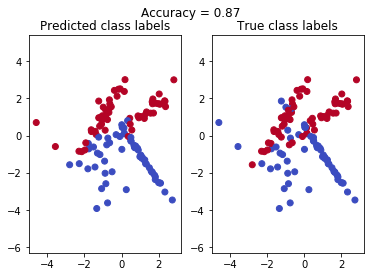

In [233]:
clf1 = DecisionTree(max_depth=4, min_samples_split=2, criterion='entropy')
clf1.fit(X_train, y_train)

print_results_clf(clf1)

Now compare our results with `sklearn`

In [234]:
from sklearn.tree import DecisionTreeClassifier

Accuracy: 0.875
predict_proba works!


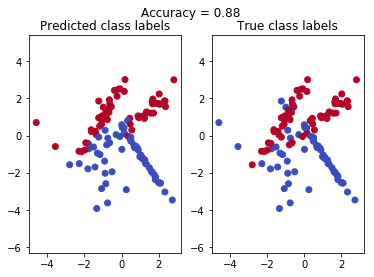

In [235]:
clf2 = DecisionTreeClassifier(max_depth=4, min_samples_split=2, criterion='entropy')
clf2.fit(X_train, y_train)

print_results_clf(clf2)

There is a scope of improvement in our classification model. Still our results are pretty good.

### Regression

In [236]:
# Prepare a synthetic data for regression
X, y = make_regression(n_features=1, n_samples=200, bias=0, noise=5,
                      random_state=RANDOM_STATE)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [237]:
# print results of trained regression model
def print_results_reg(model):
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)

    plt.scatter(X_test[:, 0], y_test, color='black')
    plt.scatter(X_test[:, 0], y_pred, color='green')
    plt.title("MSE = {0:.2f}".format(mse));

Test our implementation results

Mean Squared Error: 219.56455483815384


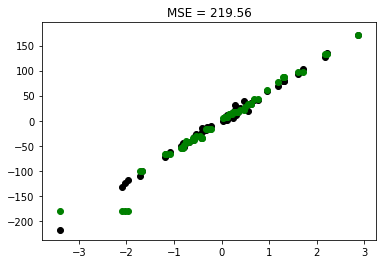

In [238]:
reg1 = DecisionTree(max_depth=6, min_samples_split=2, criterion='mse')
reg1.fit(X_train, y_train)
print_results_reg(reg1)

Now compare our results with `sklearn`

In [239]:
from sklearn.tree import DecisionTreeRegressor

Mean Squared Error: 81.96624081494176


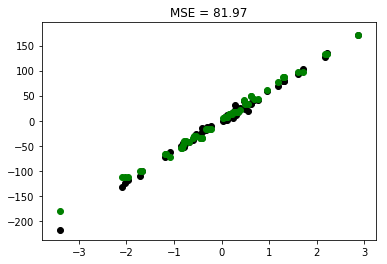

In [240]:
reg2 = DecisionTreeRegressor(max_depth=6, min_samples_split=2, criterion='mse')
reg2.fit(X_train, y_train)
print_results_reg(reg2)

Mean squared error, the lower the better. We also have improvement scope in our regressor, still it is good comparatively.